In [2]:
import torch
import torch as th
import torch.nn as nn
from torch import Tensor

import copy
import random
import numpy as np
import matplotlib as mpl

import rsatoolbox

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"


In [3]:
# Notebook support or argpase
import sys; sys.argv=['']; del sys

# General config related
from configurator import get_arg_dict, generate_args

# Env config related
from ss_baselines.av_nav.config import get_config
from ss_baselines.savi.config.default import get_config as get_savi_config
from ss_baselines.common.env_utils import construct_envs
from ss_baselines.common.environments import get_env_class

# region: Generating additional hyparams
CUSTOM_ARGS = [
    # General hyper parameters
    get_arg_dict("seed", int, 111),
    get_arg_dict("total-steps", int, 1_000_000),

    # SS env config
    get_arg_dict("config-path", str, "env_configs/audiogoal_rgb_nocont.yaml"),

    # PPO Hyper parameters
    get_arg_dict("num-envs", int, 1), # Number of parallel envs. 10 by default
    get_arg_dict("num-steps", int, 150), # For each env, how many steps are collected to form PPO Agent rollout.
    get_arg_dict("num-minibatches", int, 1), # Number of mini-batches the rollout data is split into to make the updates
    get_arg_dict("update-epochs", int, 4), # Number of gradient step for the policy and value networks
    get_arg_dict("gamma", float, 0.99),
    get_arg_dict("gae-lambda", float, 0.95),
    get_arg_dict("norm-adv", bool, True, metatype="bool"),
    get_arg_dict("clip-coef", float, 0.1), # Surrogate loss clipping coefficient
    get_arg_dict("clip-vloss", bool, True, metatype="bool"),
    get_arg_dict("ent-coef", float, 0.2), # Entropy loss coef; 0.2 in SS baselines
    get_arg_dict("vf-coef", float, 0.5), # Value loss coefficient
    get_arg_dict("max-grad-norm", float, 0.5),
    get_arg_dict("target-kl", float, None),
    get_arg_dict("lr", float, 2.5e-4), # Learning rate
    get_arg_dict("optim-wd", float, 0), # weight decay for adam optim
    ## Agent network params
    get_arg_dict("agent-type", str, "ss-default", metatype="choice",
        choices=["ss-default", "deep-etho",
                    "perceiver-gwt-gwwm", "perceiver-gwt-attgru"]),
    get_arg_dict("hidden-size", int, 512), # Size of the visual / audio features and RNN hidden states 
    ## Perceiver / PerceiverIO params: TODO: num_latnets, latent_dim, etc...
    get_arg_dict("pgwt-latent-type", str, "randn", metatype="choice",
        choices=["randn", "zeros"]), # Depth of the Perceiver
    get_arg_dict("pgwt-latent-learned", bool, True, metatype="bool"),
    get_arg_dict("pgwt-depth", int, 1), # Depth of the Perceiver
    get_arg_dict("pgwt-num-latents", int, 8),
    get_arg_dict("pgwt-latent-dim", int, 64),
    get_arg_dict("pgwt-cross-heads", int, 1),
    get_arg_dict("pgwt-latent-heads", int, 4),
    get_arg_dict("pgwt-cross-dim-head", int, 64),
    get_arg_dict("pgwt-latent-dim-head", int, 64),
    get_arg_dict("pgwt-weight-tie-layers", bool, False, metatype="bool"),
    get_arg_dict("pgwt-ff", bool, False, metatype="bool"),
    get_arg_dict("pgwt-num-freq-bands", int, 6),
    get_arg_dict("pgwt-max-freq", int, 10.),
    get_arg_dict("pgwt-use-sa", bool, False, metatype="bool"),
    ## Peceiver Modality Embedding related
    get_arg_dict("pgwt-mod-embed", int, 0), # Learnable modality embeddings
    ## Additional modalities
    get_arg_dict("pgwt-ca-prev-latents", bool, True, metatype="bool"), # if True, passes the prev latent to CA as KV input data

    # Logging params
    # NOTE: While supported, video logging is expensive because the RGB generation in the
    # envs hogs a lot of GPU, especially with multiple envs 
    get_arg_dict("save-videos", bool, False, metatype="bool"),
    get_arg_dict("save-model", bool, True, metatype="bool"),
    get_arg_dict("log-sampling-stats-every", int, int(1.5e3)), # Every X frames || steps sampled
    get_arg_dict("log-training-stats-every", int, int(10)), # Every X model update
    get_arg_dict("logdir-prefix", str, "./logs/") # Overrides the default one
]
args = generate_args(CUSTOM_ARGS)

# Additional PPO overrides
args.batch_size = int(args.num_envs * args.num_steps)
args.minibatch_size = int(args.batch_size // args.num_minibatches)

# Load environment config
is_SAVi = str.__contains__(args.config_path, "savi")
if is_SAVi:
    env_config = get_savi_config(config_paths=args.config_path)
else:
    env_config = get_config(config_paths=args.config_path)
# endregion: Generating additional hyparams

In [4]:
# Overriding some envs parametes from the .yaml env config
env_config.defrost()
env_config.NUM_PROCESSES = 1 # Corresponds to number of envs, makes script startup faster for debugs
env_config.USE_SYNC_VECENV = True
# env_config.USE_VECENV = False
# env_config.CONTINUOUS = args.env_continuous
## In caes video saving is enabled, make sure there is also the rgb videos
env_config.freeze()
# print(env_config)

# Environment instantiation
envs = construct_envs(env_config, get_env_class(env_config.ENV_NAME))
single_observation_space = envs.observation_spaces[0]
single_action_space = envs.action_spaces[0]

single_observation_space, single_action_space

2022-10-26 15:03:12,233 Initializing dataset AudioNav
2022-10-26 15:03:12,245 Initializing dataset AudioNav
2022-10-26 15:04:21,197 initializing sim SoundSpacesSim
2022-10-26 15:04:21,761 Initializing task AudioNav


(Dict(audiogoal:Box(-3.4028235e+38, 3.4028235e+38, (2, 16000), float32), rgb:Box(0, 255, (128, 128, 3), uint8), spectrogram:Box(-3.4028235e+38, 3.4028235e+38, (65, 26, 2), float32)),
 ActionSpace(MOVE_FORWARD:EmptySpace(), STOP:EmptySpace(), TURN_LEFT:EmptySpace(), TURN_RIGHT:EmptySpace()))

In [45]:
# TODO seeding for reproducibility ? Make sure that we can control the generated episode trajs ?

# Loading pretrained agent
import models
from models import ActorCritic, Perceiver_GWT_GWWM_ActorCritic

MODEL_VARIANTS_TO_STATEDICT_PATH = {
    # Baseline variants: BC
    "ppo_gru__bc": {
        "pretty_name": "PPO GRU (BC)",
        "state_dict_path": 
            "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
            "ppo_bc2__ss1_rgb_spectro__gru__bsize_32_bchnklen_32__nsteps_50__cew_38.6_0.67_0.84_0.78_nogradnorm_seed_111__2022_10_08_17_24_31_002321.musashi"
            # "/models/ppo_agent.3990001.ckpt.pth"
            "/models/ppo_agent.990001.ckpt.pth"
    },
    "ppo_pgwt__bc": {
        "pretty_name": "PPO PGWT (BC)",
        "state_dict_path": 
            "/home/rousslan/random/rl/exp-logs/ss-hab-bc/"
            "ppo_bc2__ss1_rgb_spectro__pgwt_gwwm__dpth_1_nlats_8_latdim_64_noSA_CAprevlats__bsize_32_bchnklen_32__nsteps_50__cew_38.6_0.67_0.84_0.78_nogradnorm_seed_111__2022_10_08_17_24_31_001985.musashi"
            # "/models/ppo_agent.3990001.ckpt.pth"
            "/models/ppo_agent.990001.ckpt.pth"
    },

    # Baselin variants: RL
    # "ppo_gru__rl": {
    #     "pretty_name": "PPO GRU (RL)",
    #     "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab/ppo_av_nav__ss1_rgb_spectro_seed_111__2022_09_06_13_59_13_931240.musashi"
    #     "/models/ppo_agent.994501.ckpt.pth"
    # },
    # "ppo_pgwt__rl": {
    #     "pretty_name": "PPO PGWT (RL)",
    #     "state_dict_path": "/home/rousslan/random/rl/exp-logs/ss-hab/ppo_av_nav__ss1_rgb_spectro__pgwt_gwwm__dpth_1_nlats_8_latdim_64_noSA_CAnheads_1_SAnheads_4_modembed_0_CAprevlats_seed_111__2022_09_06_14_43_49_094181.musashi"
    #     "/models/ppo_agent.993001.ckpt.pth"
    # },
    
    # Other variants
    ## PPO GRU and PGWT varaint with features detache for value backprop
    "ppo_gru__rl__valdet": {
        "pretty_name": "PPO GRU (RL - Val. Det.)",
        "state_dict_path":
            "/home/rousslan/random/rl/exp-logs/ss-hab/"
            "ppo_av_nav__ss1_rgb_spectro__value_feat_detach_seed_111__2022_10_14_10_55_46_905926.musashi"
            "/models/ppo_agent.957001.ckpt.pth"
    },
    "ppo_pgwt__rl_valdet": {
        "pretty_name": "PPO PGWT (RL - Val. Det.)",
        "state_dict_path": 
            "/home/rousslan/random/rl/exp-logs/ss-hab/"
            "ppo_av_nav__ss1_rgb_spectro__pgwt_gwwm__dpth_1_nlats_8_latdim_64_noSA_CAnheads_1_SAnheads_4_modembed_0_CAprevlats__value_feat_detach_seed_111__2022_10_14_10_25_00_965286.musashi"
            "/models/ppo_agent.987001.ckpt.pth"
    },

    ## PPO GRU with features detached for policy backprop
    # "ppo_gru__rl__poldet": {
    #     "pretty_name": "PPO GRU (RL - Pol. Det.)",
    #     "state_dict_path":
    #         "/home/rousslan/random/rl/exp-logs/ss-hab/"
    #         "ppo_av_nav__ss1_rgb_spectro__actor_feat_detach_seed_111__2022_10_14_17_27_11_291954.musashi"
    #         "/models/ppo_agent.982501.ckpt.pth"
    # },
    # "ppo_pgwt__rl_poldet": {
    #     "pretty_name": "PPO PGWT (RL - Pol. Det.)",
    #     "state_dict_path": 
    #         "/home/rousslan/random/rl/exp-logs/ss-hab/"
    #         "ppo_av_nav__ss1_rgb_spectro__pgwt_gwwm__dpth_1_nlats_8_latdim_64_noSA_CAnheads_1_SAnheads_4_modembed_0_CAprevlats__actor_feat_detach_seed_111__2022_10_14_17_27_11_508537.musashi"
    #         "/models/ppo_agent.982501.ckpt.pth"
    # }

    # Random baselines
    # "ppo_gru__random": {
    #     "pretty_name": "PPO GRU (Rndm)",
    #     "state_dict_path": ""
    # },
    # "ppo_pgwt__random": {
    #     "pretty_name": "PPO PGWT (Rndm)",
    #     "state_dict_path": ""
    # },
}

# 'variant named' indexed 'torch agent'
MODEL_VARIANTS_TO_AGENTMODEL = {}

for k, v in MODEL_VARIANTS_TO_STATEDICT_PATH.items():
    args_copy = copy.copy(args)
    # Override args depending on the model in use
    if k.__contains__("gru"):
        agent = ActorCritic(single_observation_space, single_action_space, args.hidden_size, extra_rgb=False,
            analysis_layers=models.GRU_ACTOR_CRITIC_DEFAULT_ANALYSIS_LAYER_NAMES)
    elif k.__contains__("pgwt"):
        agent = Perceiver_GWT_GWWM_ActorCritic(single_observation_space, single_action_space, args, extra_rgb=False,
            analysis_layers=models.PGWT_GWWM_ACTOR_CRITIC_DEFAULT_ANALYSIS_LAYER_NAMES)

    agent.eval()
    # Load the model weights
    # TODO: add map location device to use CPU only ?
    if v["state_dict_path"] != "":
        agent_state_dict = th.load(v["state_dict_path"])
        agent.load_state_dict(agent_state_dict)
    
    MODEL_VARIANTS_TO_AGENTMODEL[k] = agent

In [46]:
# Collecting episode data for feature extraction later
# TODO: manually inspect and dave episdoe data, form a list of around 500 or 1000 observations
# TODO: also need to make sure which agent is used to sample it. Ideally, one of the RL agents that
# has a good enough success rate

## Helper
dev = th.device("cpu")
def tensorize_obs_dict(obs, device, observations=None, rollout_step=None):
    obs_th = {}
    for obs_field, _ in obs[0].items():
        v_th = th.Tensor(np.array([step_obs[obs_field] for step_obs in obs], dtype=np.float32)).to(device)
        # in SS1.0, the dcepth observations comes as [B, 128, 128, 1, 1], so fix that
        if obs_field == "depth" and v_th.dim() == 5:
            v_th = v_th.squeeze(-1)
        obs_th[obs_field] = v_th
        # Special case when doing the rollout, also stores the 
        if observations is not None:
            observations[obs_field][rollout_step] = v_th
    
    return obs_th

obs_list, reward_list, done_list, info_list, action_list = [], [], [], [], []
obs_th_list, done_th_list = [], [] 

rnn_hidden_state = th.zeros((1, args.num_envs, args.hidden_size), device=dev)

obs, done = envs.reset(), [False for _ in range(args.num_envs)]
done_th = th.Tensor(done).to(dev)
masks = 1. - done_th[:, None]

MAX_STEPS = 256
collected_steps = 0

# while not done_th.sum() and collected_steps < MAX_STEPS:
#     obs_th = tensorize_obs_dict(obs, dev)
#     done_th = th.Tensor(done).to(dev)
#     with th.no_grad():
#         action, action_probs, action_logprobs, _, value, rnn_hidden_state = \
#             MODEL_VARIANTS_TO_AGENTMODEL["ppo_gru__rl"].act(obs_th, rnn_hidden_state, masks=masks)
    
#     outputs = envs.step([a[0].item() for a in action])
#     next_obs, reward, next_done, info = [list(x) for x in zip(*outputs)]

#     # NOTE obs_list and done_list would have one extra position than info_list
#     obs_list.append(obs)
#     done_list.append(done)
#     obs_th_list.append(obs_th)
#     done_th_list.append(done_th)

#     reward_list.append(reward)
#     info_list.append(info)
#     action_list.append(action.cpu().numpy())

#     # Prepare for the next step
#     obs = next_obs
#     done = next_done

#     collected_steps += 1
#     # DEBUG: producing shorter sequence for downstream tests
#     # if len(obs_list) >= 100:
#     #     break

# len(obs_list) # Episode length

In [47]:
# Alternatively, load data from manually saved data
import pickle as pkl

with open("obs_list__2022_09_21_13_35_dump.pkl", "rb") as f:
    obs_list = pkl.load(f)

obs_list = obs_list[:80] # Manual capping for better visibility

# Match the expected format of the obs_th_list and done_th_list below
# type(done_th_list), len(done_th_list) # (list, 21)
# type(done_th_list[0]), len(done_th_list[0]) # (torch.Tensor, 1)
done_th_list2 = [th.Tensor([0]) for _ in range(len(obs_list))]
# type(done_th_list2), len(done_th_list2) # (list, 80)
# type(done_th_list2[0]), len(done_th_list2[0]) # (torch.Tensor, 1)


# type(obs_th_list), len(obs_th_list)
# type(obs_th_list[0]), len(obs_th_list[0]), list(obs_th_list[0].keys()) # (dict, 3, ['rgb', 'audiogoal', 'spectrogram'])
# [v.shape for v in obs_th_list[0].values()] # [torch.Size([1, 128, 128, 3]), torch.Size([1, 2, 16000]), torch.Size([1, 65, 26, 2])]

obs_th_list2 = [{k: th.Tensor(v)[None, :] for k,v in obs_list[i][0].items()} for i in range(len(obs_list))]
# type(obs_th_list2[0]), len(obs_th_list2[0]), list(obs_th_list2[0].keys()) # (dict, 3, ['rgb', 'audiogoal', 'spectrogram']), matching 'obs_th_list" expecteation
# [v.shape for v in obs_th_list2[0].values()] # [torch.Size([1, 128, 128, 3]), torch.Size([1, 2, 16000]), torch.Size([1, 65, 26, 2])]

# TODO: if stacking different episodes together, we would also need the done data

In [117]:
# For the collected observation samples, record the intermediate features
# for each agent varaint investigated

AGENT_FEATURES__RAW = {k: {} for k in MODEL_VARIANTS_TO_AGENTMODEL.keys()}
AGENT_RNN_HIDDEN_STATE = {}
for agent_variant, agent_model in MODEL_VARIANTS_TO_AGENTMODEL.items():
    if agent_variant.__contains__("gru"):
        AGENT_RNN_HIDDEN_STATE[agent_variant] = th.zeros((1, args.num_envs, args.hidden_size), device=dev)
    elif agent_variant.__contains__("pgwt"):
        AGENT_RNN_HIDDEN_STATE[agent_variant] = agent_model.state_encoder.latents.clone()

# TODO: Add tqdm support ?
# for t, (obs_th, done_th) in enumerate(zip(obs_th_list, done_th_list)):
for t, (obs_th, done_th) in enumerate(zip(obs_th_list2, done_th_list2)):
    # TODO: if multiple episodes are cated together, need to make sure that the done_th_list reflects that
    # other the hidden latents will not be reset

    # Feeding the same sequence of observatiosn to each type of agent
    masks = 1. - done_th[:, None]
    with th.no_grad():
        for agent_variant, agent_model in MODEL_VARIANTS_TO_AGENTMODEL.items():
            # NOTE: rnn_hidden_state or pgwt's latent are already collected in "state_encoder" field in _features
            _, _, _, _, _, AGENT_RNN_HIDDEN_STATE[agent_variant] = \
                agent_model.act(obs_th, AGENT_RNN_HIDDEN_STATE[agent_variant], masks)

            # Collecting intermediate layers results
            for k, v in agent_model._features.items():
                if k not in list(AGENT_FEATURES__RAW[agent_variant].keys()):
                    AGENT_FEATURES__RAW[agent_variant][k] = []
                AGENT_FEATURES__RAW[agent_variant][k].append(v)

# After recording the intermediate layers features, process them to handle the 
# various shape depending on the layers: for example MHA has different stored features
# shape than GRU network, and so on.

## Helper for cleaning up and preparing the recorded intermediate features
def process_analysis_feats_raw(raw_dict):
    result_dict = {}

    for k, v in raw_dict.items():
        if isinstance(v[0], th.Tensor):
            new_v = th.cat(v, dim=0)
        elif isinstance(v[0], tuple):
            new_v = None # TODO
            n_elements = len(v[0])
            elements = [[] for _ in range(n_elements)]
            for j in range(n_elements):
                for i in range(len(v)):
                    elements[j].append(v[i][j])
            
            new_v = [th.cat(vv, dim=0) for vv in elements]
        else:
            raise Exception(f"Unhandled type: {v[0].__class__}")
    
        result_dict[k] = new_v
    
    return result_dict

AGENT_FEATURES = {} # { agent_variant -> agent_feature_dict }
for k, v in AGENT_FEATURES__RAW.items():
    AGENT_FEATURES[k] = process_analysis_feats_raw(v)

In [56]:
# Prototypoing ISC distance
variant_features = AGENT_FEATURES["ppo_gru__bc"]["state_encoder"][0] # Extract the features of the state encoder (RNN cell)
# variant_features.cpu().numpy() # (80, 512)
variant_data = rsatoolbox.data.Dataset(variant_features.cpu().numpy())
variant_data, variant_data.measurements.shape

from copy import deepcopy
from rsatoolbox.rdm.rdms import RDMs
from rsatoolbox.data import average_dataset_by
from rsatoolbox.util.rdm_utils import _extract_triu_

from sklearn import preprocessing
from scipy import spatial

In [118]:
def _parse_input(dataset, descriptor):
    if descriptor is None:
        measurements = dataset.measurements
        desc = np.arange(measurements.shape[0])
        descriptor = 'pattern'
    else:
        measurements, desc, _ = average_dataset_by(dataset, descriptor)
    return measurements, desc, descriptor

# TODO: cosine similarity to evaluate similarity ?

def calc_rdm_cosine_dist(dataset, descriptor=None):
    measurements, desc, descriptor = _parse_input(dataset, descriptor)
    N, M = measurements.shape

    rdm = np.array([[spatial.distance.cdist(measurements[j][None, :], measurements[k][None, :], "correlation")[0][0] for k in range(N)] for j in range(N)])
    rdm = _extract_triu_(rdm) / measurements.shape[1]
    rdm = RDMs(dissimilarities=np.array([rdm]),
               dissimilarity_measure='correlation',
               rdm_descriptors=deepcopy(dataset.descriptors))
    rdm.pattern_descriptors[descriptor] = desc
    return rdm

def normalize_to_l1_one(measurements):
    l1_norm = np.linalg.norm(measurements, ord=1, axis=1, keepdims=True)
    normalized_measurements = abs(measurements) / l1_norm.repeat(measurements.shape[-1], axis=-1)
    return normalized_measurements

# NOTE: this is probalby not correct
def calc_rdm_isc_2(dataset, descriptor=None):
    """
    Args:
        dataset (rsatoolbox.data.DatasetBase):
            The dataset the RDM is computed from
        descriptor (String):
            obs_descriptor used to define the rows/columns of the RDM
            defaults to one row/column per row in the dataset
    Returns:
        rsatoolbox.rdm.rdms.RDMs: RDMs object with the one RDM
    """

    measurements, desc, descriptor = _parse_input(dataset, descriptor)
    
    # In Eq. 5, each document is normalized to 1 in L1 norm: ∑mi=1xi=1. 
    l1_unit_norm = normalize_to_l1_one(measurements)

    N, M = l1_unit_norm.shape
    rdm = np.zeros((N, N))
    # TODO: more efficient computation based on matrices ?
    for j in range(N):
        for k in range(N):
            x, y = l1_unit_norm[j], l1_unit_norm[k]
            numerator = np.sum(np.sqrt(x * y)) # \sum_i=1^M sqrt(x_i * y_i)
            denominator = np.sqrt(np.sum(x)) * np.sqrt(np.sum(y))
            # ISC disctance computation
            rdm[j, k] = numerator / denominator
    
    rdm = _extract_triu_(rdm) / measurements.shape[1]
    rdm = RDMs(dissimilarities=np.array([rdm]),
               dissimilarity_measure='improved squared cosine',
               rdm_descriptors=deepcopy(dataset.descriptors))
    rdm.pattern_descriptors[descriptor] = desc
    return rdm

def calc_rdm_isc(dataset, descriptor=None):
    """
    Args:
        dataset (rsatoolbox.data.DatasetBase):
            The dataset the RDM is computed from
        descriptor (String):
            obs_descriptor used to define the rows/columns of the RDM
            defaults to one row/column per row in the dataset
    Returns:
        rsatoolbox.rdm.rdms.RDMs: RDMs object with the one RDM
    """

    measurements, desc, descriptor = _parse_input(dataset, descriptor)
    N, M = measurements.shape
    rdm = np.zeros((N, N))
    # TODO: more efficient computation based on matrices ?
    for j in range(N):
        for k in range(N):
            x, y = measurements[j], measurements[k]
            numerator = np.sum(np.sqrt(x * y)) # \sum_i=1^M sqrt(x_i * y_i)
            denominator = np.sqrt(np.sum(x)) * np.sqrt(np.sum(y))
            # ISC disctance computation
            rdm[j, k] = numerator / denominator
    
    rdm = _extract_triu_(rdm) / measurements.shape[1]
    rdm = RDMs(dissimilarities=np.array([rdm]),
               dissimilarity_measure='improved squared cosine',
               rdm_descriptors=deepcopy(dataset.descriptors))
    rdm.pattern_descriptors[descriptor] = desc
    return rdm

# rdm = calc_rdm_euclid(variant_data); rdm.dissimilarities.shape
rdm = calc_rdm_cosine_dist(variant_data); rdm.dissimilarities.shape
# rdm = calc_rdm_isc_2(variant_data); rdm.dissimilarities.shape
# rdm = calc_rdm_isc(variant_data); rdm.dissimilarities.shape

# Custom dissimilarity metrics computatoins

(1, 3160)

In [119]:
# variant_data.measurements[0][None, :].shape
spatial.distance.cdist(variant_data.measurements[0][None, :], variant_data.measurements[1][None, :], "correlation")

array([[0.00087392]])

In [124]:
# Systematic plotting for each shared intermediate layers
all_layers = []
for v in AGENT_FEATURES.values():
    all_layers.extend(v.keys())
all_layers = set(all_layers); all_layers

# Extract shared layers, and other groups of layers of interest
shared_layers = []
visual_encoder_layernames = []
audio_encoder_layernames = []
for x in all_layers:
    x_found_in_all = True
    for v in AGENT_FEATURES.values():
        if x not in v.keys():
            x_found_in_all = False
            break
    
    if x_found_in_all:
        shared_layers.append(x)
    
    if x.startswith("visual_encoder"):
        visual_encoder_layernames.append(x)
    if x.startswith("audio_encoder"):
        audio_encoder_layernames.append(x)

# Pre-compute all sparsities
# Helper method
def compute_sparsity(response_list):
    n_images, n_neurons = response_list.shape
    neurons_sparsity_list = []
    
    for i in range(n_neurons):
        # TODO: properly handle the NaN that occurs when the response is 0
        a = (response_list[:, i].sum().pow(2) + 1e-8) / (response_list[:, i].pow(2).sum() + 1e-8)
        b = 1 / n_images
        neurons_sparsity_list.append( (1 - (b * a)) / (1 - b))
    
    return np.array(neurons_sparsity_list)

VARIANT_LAYERS_SPARSITIES = {k: {} for k in MODEL_VARIANTS_TO_STATEDICT_PATH.keys()}

# NOTE: manually chose the metric for the RDM computation
# DISS_CALC_FN = rsatoolbox.rdm.calc_rdm_euclid
DISS_CALC_FN = rsatoolbox.rdm.calc_rdm_correlation
# DISS_CALC_FN = calc_rdm_cosine_dist # Custom Cosine distance (dissimilarity)
# DISS_CALC_FN = calc_rdm_isc # Custom 'Improved Sqrd Root' 

# Placeholder for the whole RDMs for each agent varaint
VARIANTS_RDMS = {k: {} for k in AGENT_FEATURES.keys()}
# Placeholder for the mean and std of the dissimilaritie for each variant
VARIANT_RDMS_MEAN_STD = {k: {} for k in AGENT_FEATURES.keys()}

for layername in sorted(shared_layers):
    for agent_variant, agent_variant_features in AGENT_FEATURES.items():
        variant_layer_features = agent_variant_features[layername]
        if isinstance(variant_layer_features, list):
            # If the features record for a given layer are a "list", then it is probablye al yaer
            # like the MHA state_encoder, which returns more than one output: flat state_features,
            # and the non flattented varianst: [B, NUM_LATENTS, LATENT_DIM]S. Using [0] just takes
            # the flattened version anyway, then futher flattens it over a batch ?
            variant_features = variant_layer_features[0].flatten(start_dim=1)
        else:
            # if it is not a list, then it is probably a tensor. For example the outout of an nn.Linear
            # or state features outpout by a GRU-based StateEncoder component in the agent
            variant_features = variant_layer_features.flatten(start_dim=1)

        variant_data = rsatoolbox.data.Dataset(variant_features.cpu().numpy())
        # Compute the RDMs for the given agent variant
        variant_rdm = DISS_CALC_FN(variant_data)
        
        # Store the RDMs for subsequent plots
        VARIANTS_RDMS[agent_variant][layername] = variant_rdm

        # Pre-compute the mean and std of dissmilarities for the current layer of the current variant
        VARIANT_RDMS_MEAN_STD[agent_variant][layername] = {
            "mean": np.mean(variant_rdm.dissimilarities),
            "std": np.std(variant_rdm.dissimilarities)
        }

        # Variant's layerwise sparsity
        VARIANT_LAYERS_SPARSITIES[agent_variant][layername] = compute_sparsity(variant_features)

/home/rousslan/anaconda3/envs/ss-hab-headless-py39/lib/python3.9/site-packages/rsatoolbox/rdm/calc.py:209: RuntimeWarning: invalid value encountered in true_divide
  ma /= np.sqrt(np.einsum('ij,ij->i', ma, ma))[:, None]


In [125]:
# What is this even for ?
# variant_features = AGENT_FEATURES["ppo_gru__bc"]["critic.fc"].flatten(start_dim=1)
# # variant_features = AGENT_FEATURES["ppo_gru__bc"]["state_encoder"][0].flatten(start_dim=1)
# variant_features.cpu().numpy().shape
# variant_data = rsatoolbox.data.Dataset(variant_features.cpu().numpy())
# variant_rdm = DISS_CALC_FN(variant_data)
# variant_rdm.dissimilarities.shape
# # np.mean(variant_rdm.dissimilarities)

In [126]:
# # Average dissimilarities overview plots
# # TODO: make it a single plot later, with one subplots for each different componets ?
# # TODO: In case we have more than 4 variants, it might be preferable change the plotting scheem
# #       to have the layers name as in the reference paper, and the variant names on the x-axis,
# #       at least for the average dissmilarities plots ?

# N_VARIANTS = len(VARIANT_RDMS_MEAN_STD.keys())
# VARIANTS_COLOR_PALETTE = sns.color_palette(n_colors=N_VARIANTS)
# VARIANTS_BAR_SHIFTING = np.linspace(-0.1, 0.1, N_VARIANTS)

# ## Visual encoder section
# visual_encoder_layernames.sort()
# visual_encoder_layernames_relu_skipped = visual_encoder_layernames[::2]

# n_rows, n_cols = 1, 1
# fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, n_rows * 6))

# x = np.arange(len(visual_encoder_layernames_relu_skipped)) # 2 PPO varaint per plot for each layer


# for t, (agent_variant, agent_varaint_rdms_mean_std_dict) in enumerate(VARIANT_RDMS_MEAN_STD.items()):
#     y = [agent_varaint_rdms_mean_std_dict[lynm]["mean"] for lynm in visual_encoder_layernames_relu_skipped]
#     yerr = [agent_varaint_rdms_mean_std_dict[lynm]["std"] for lynm in visual_encoder_layernames_relu_skipped]

#     ax.errorbar(x-VARIANTS_BAR_SHIFTING[t], y, yerr, fmt="none",
#                  elinewidth=3, label=MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], color=VARIANTS_COLOR_PALETTE[t])

# ax.set_xlabel("Layers")
# ax.set_ylabel("Average Dissimilarity")
# ax.legend()
# ax.set_xticks(x)
# ax.set_xticklabels(visual_encoder_layernames_relu_skipped)
# fig.suptitle("Whitened Cosine | Avg. Dissimilarity across layers | Visual Encoder\n(Higher values -> more different)")
# fig.tight_layout()
# fig.show()

# ## Audio encoder section
# audio_encoder_layernames.sort()
# audio_encoder_layernames_relu_skipped = audio_encoder_layernames[::2]

# n_rows, n_cols = 1, 1
# fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, n_rows * 6))

# x = np.arange(len(audio_encoder_layernames_relu_skipped)) # 2 PPO varaint per plot for each layer

# for t, (agent_variant, agent_varaint_rdms_mean_std_dict) in enumerate(VARIANT_RDMS_MEAN_STD.items()):
#     y = [agent_varaint_rdms_mean_std_dict[lynm]["mean"] for lynm in audio_encoder_layernames_relu_skipped]
#     yerr = [agent_varaint_rdms_mean_std_dict[lynm]["std"] for lynm in audio_encoder_layernames_relu_skipped]

#     ax.errorbar(x-VARIANTS_BAR_SHIFTING[t], y, yerr, fmt="none",
#                  elinewidth=3, label=MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], color=VARIANTS_COLOR_PALETTE[t])

# ax.set_xlabel("Layers")
# ax.set_ylabel("Average Dissimilarity")
# ax.legend()
# ax.set_xticks(x)
# ax.set_xticklabels(audio_encoder_layernames_relu_skipped)
# fig.suptitle("Whitened Cosine | Avg. Dissimilarity across layers | Audio Encoder\n(Higher values -> more different)")
# fig.tight_layout()
# fig.show()

# ## State features
# n_rows, n_cols = 1, 1
# fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, n_rows * 6))

# for t, (agent_variant, agent_varaint_rdms_mean_std_dict) in enumerate(VARIANT_RDMS_MEAN_STD.items()):
#     y = agent_varaint_rdms_mean_std_dict["state_encoder"]["mean"]
#     yerr = agent_varaint_rdms_mean_std_dict["state_encoder"]["std"]

#     ax.errorbar(1-VARIANTS_BAR_SHIFTING[t], y, yerr, fmt="none",
#                  elinewidth=3, label=MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], color=VARIANTS_COLOR_PALETTE[t])

# ax.set_ylabel("Average Dissimilarity")
# ax.legend()
# ax.set_xticks([1])
# ax.set_xticklabels(["state_encoder"])
# ax.set_xlim(0.5, 1.5)
# fig.suptitle("Whitened Cosine | Avg. Dissimilarity of 'state features' \n(Higher values -> more different)")
# fig.tight_layout()
# fig.show()

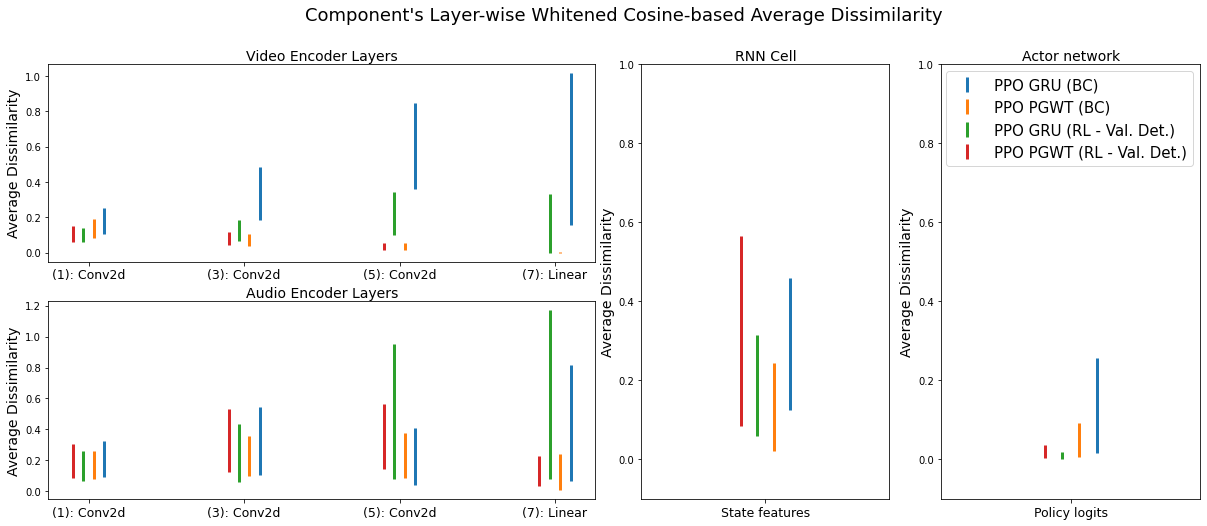

In [127]:
# All in one plots
from matplotlib.gridspec import GridSpec # TODO: move to the top

N_VARIANTS = len(VARIANT_RDMS_MEAN_STD.keys())
VARIANTS_COLOR_PALETTE = sns.color_palette(n_colors=N_VARIANTS)
VARIANTS_BAR_SHIFTING = np.linspace(-0.1, 0.1, N_VARIANTS)

fig = plt.figure(figsize=(16,8))

# Visual and audo encoder layers
gs1 = GridSpec(2, 1, left=0.0, right=0.475, wspace=0)

## Video encoder layers
vis_enc_ax = fig.add_subplot(gs1[0, 0])

visual_encoder_layernames.sort()
visual_encoder_layernames_relu_skipped = visual_encoder_layernames[::2]
x = np.arange(len(visual_encoder_layernames_relu_skipped)) # 2 PPO varaint per plot for each layer

for t, (agent_variant, agent_variant_drms_mean_std_dict) in enumerate(VARIANT_RDMS_MEAN_STD.items()):
    y = [agent_variant_drms_mean_std_dict[lynm]["mean"] for lynm in visual_encoder_layernames_relu_skipped]
    yerr = [agent_variant_drms_mean_std_dict[lynm]["std"] for lynm in visual_encoder_layernames_relu_skipped]

    vis_enc_ax.errorbar(x-VARIANTS_BAR_SHIFTING[t], y, yerr, fmt="none",
                 elinewidth=3, label=MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], color=VARIANTS_COLOR_PALETTE[t])

vis_enc_ax.set_xlabel("Video Encoder Layers", fontsize=14)
vis_enc_ax.xaxis.set_label_position("top")
vis_enc_ax.set_ylabel("Average Dissimilarity", fontsize=14)
vis_enc_ax.set_xticks(x)
visual_encoder_layernames_relu_skipped_pretty_names = ["(1): Conv2d", "(3): Conv2d", "(5): Conv2d", "(7): Linear"]
vis_enc_ax.set_xticklabels(visual_encoder_layernames_relu_skipped_pretty_names, fontsize=12.5)
# vis_enc_ax.legend()

## Audo encoder layers
aud_enc_ax = fig.add_subplot(gs1[1, 0])

audio_encoder_layernames.sort()
audio_encoder_layernames_relu_skipped = audio_encoder_layernames[::2]

x = np.arange(len(audio_encoder_layernames_relu_skipped)) # 2 PPO varaint per plot for each layer

for t, (agent_variant, agent_varaint_rdms_mean_std_dict) in enumerate(VARIANT_RDMS_MEAN_STD.items()):
    y = [agent_varaint_rdms_mean_std_dict[lynm]["mean"] for lynm in audio_encoder_layernames_relu_skipped]
    yerr = [agent_varaint_rdms_mean_std_dict[lynm]["std"] for lynm in audio_encoder_layernames_relu_skipped]

    aud_enc_ax.errorbar(x-VARIANTS_BAR_SHIFTING[t], y, yerr, fmt="none",
                 elinewidth=3, label=MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], color=VARIANTS_COLOR_PALETTE[t])

aud_enc_ax.set_xlabel("Audio Encoder Layers", fontsize=14)
aud_enc_ax.xaxis.set_label_position("top")
aud_enc_ax.set_ylabel("Average Dissimilarity", fontsize=14)
aud_enc_ax.set_xticks(x)
audio_encoder_layernames_relu_skipped_pretty_names = ["(1): Conv2d", "(3): Conv2d", "(5): Conv2d", "(7): Linear"]
aud_enc_ax.set_xticklabels(audio_encoder_layernames_relu_skipped_pretty_names, fontsize=12.5)
# aud_enc_ax.legend()

# State features plot
gs2 = GridSpec(1,1, left=0.515, right=0.73, wspace=0)

state_feat_ax = fig.add_subplot(gs2[0, 0])

for t, (agent_variant, agent_varaint_rdms_mean_std_dict) in enumerate(VARIANT_RDMS_MEAN_STD.items()):
    y = agent_varaint_rdms_mean_std_dict["state_encoder"]["mean"]
    yerr = agent_varaint_rdms_mean_std_dict["state_encoder"]["std"]

    state_feat_ax.errorbar(1-VARIANTS_BAR_SHIFTING[t], y, yerr, fmt="none",
                 elinewidth=3, label=MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], color=VARIANTS_COLOR_PALETTE[t])

state_feat_ax.set_ylabel("Average Dissimilarity", fontsize=14)
state_feat_ax.set_ylim(-0.1, 1)
state_feat_ax.set_xticks([1])
state_feat_ax.set_xticklabels(["State features"], fontsize=12.5)
state_feat_ax.set_xlabel("RNN Cell", fontsize=14)
state_feat_ax.xaxis.set_label_position("top")
state_feat_ax.set_xlim(0.5, 1.5)
# state_feat_ax.legend()

# State 
gs3 = GridSpec(1, 1, left=0.775, right=1, wspace=0)

## Actor componet
actor_ax = fig.add_subplot(gs3[0, 0])

for t, (agent_variant, agent_varaint_rdms_mean_std_dict) in enumerate(VARIANT_RDMS_MEAN_STD.items()):
    y = agent_varaint_rdms_mean_std_dict["action_distribution.linear"]["mean"]
    yerr = agent_varaint_rdms_mean_std_dict["action_distribution.linear"]["std"]

    actor_ax.errorbar(1-VARIANTS_BAR_SHIFTING[t], y, yerr, fmt="none",
                 elinewidth=3, label=MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], color=VARIANTS_COLOR_PALETTE[t])

actor_ax.set_ylabel("Average Dissimilarity", fontsize=14)
actor_ax.set_ylim(-0.1, 1)
actor_ax.set_xticks([1])
actor_ax.set_xticklabels(["Policy logits"], fontsize=12.5)
actor_ax.xaxis.set_label_position("top")
actor_ax.set_xlabel("Actor network", fontsize=14)
actor_ax.set_xlim(0.5, 1.5)
actor_ax.legend(fontsize=15)

## Critic omponet
# NOTE: due to its shape, there is nothing much to analyse at the critic level
# critic_ax = fig.add_subplot(gs3[1, 0])

# for t, (agent_variant, agent_varaint_rdms_mean_std_dict) in enumerate(VARIANT_RDMS_MEAN_STD.items()):
#     y = agent_varaint_rdms_mean_std_dict["critic.fc"]["mean"]
#     yerr = agent_varaint_rdms_mean_std_dict["critic.fc"]["std"]

#     critic_ax.errorbar(1-VARIANTS_BAR_SHIFTING[t], y, yerr, fmt="none",
#                  elinewidth=3, label=MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], color=VARIANTS_COLOR_PALETTE[t])

# critic_ax.set_ylabel("Average Dissimilarity", fontsize=14)
# critic_ax.set_ylim(-0.1, 1)
# critic_ax.set_xticks([1])
# critic_ax.set_xticklabels(["Value logits"], fontsize=12.5)
# critic_ax.set_xlim(0.5, 1.5)
# critic_ax.legend(fontsize=13)

fig.suptitle("Component's Layer-wise Whitened Cosine-based Average Dissimilarity", fontsize=18)
# fig.tight_layout()
fig.show()

In [76]:
# # RSA Dissimilarities plots 
# ## TODO: add colorbar

# ## General
# N_VARIANTS = len(VARIANT_RDMS_MEAN_STD.keys())

# ## Visual encoder
# visual_encoder_layernames.sort()
# visual_encoder_layernames_relu_skipped = visual_encoder_layernames[::2]

# n_rows, n_cols = N_VARIANTS, len(visual_encoder_layernames_relu_skipped)
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))
# dividers = [make_axes_locatable(a) for a in axes[:, -1]]
# caxes = [ d.append_axes('right', size='5%', pad=0.1) for d in dividers]

# # VMIN, VMAX = None, None
# VMIN, VMAX = 0, 1
# for ax_idx, layername in enumerate(visual_encoder_layernames_relu_skipped):
#     for r_idx, (agent_variant, agent_variant_rdm) in enumerate(VARIANTS_RDMS.items()):
#         im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername], ax=axes[r_idx][ax_idx],
#                                       cmap=mpl.colormaps["viridis"], vmin=VMIN, vmax=VMAX)
#         fig.colorbar(im, cax=caxes[r_idx], orientation='vertical')

#         axes[r_idx][ax_idx].set_xlabel(layername, fontsize=20, position="above")
#         axes[r_idx][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=24)

# fig.suptitle("Vis. Encoder | Layer-wise Dissimilarities Matrix Plots | (Higher values -> more different, color range: [0,1])", fontsize=26)
# fig.tight_layout()
# fig.subplots_adjust(top=0.95)
# fig.show()

# ## Audio encoder
# audio_encoder_layernames.sort()
# audio_encoder_layernames_relu_skipped = audio_encoder_layernames[::2]

# n_rows, n_cols = N_VARIANTS, len(audio_encoder_layernames_relu_skipped)
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))
# dividers = [make_axes_locatable(a) for a in axes[:, -1]]
# caxes = [ d.append_axes('right', size='5%', pad=0.1) for d in dividers]

# # VMIN, VMAX = None, None
# VMIN, VMAX = 0, 1
# for ax_idx, layername in enumerate(audio_encoder_layernames_relu_skipped):
#     for r_idx, (agent_variant, agent_variant_rdm) in enumerate(VARIANTS_RDMS.items()):
#         im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername], ax=axes[r_idx][ax_idx],
#                                       cmap=mpl.colormaps["viridis"], vmin=VMIN, vmax=VMAX)
#         fig.colorbar(im, cax=caxes[r_idx], orientation='vertical')
        
#         axes[r_idx][ax_idx].set_xlabel(layername, fontsize=20, position="above")
#         axes[r_idx][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=24)

# fig.suptitle("Aud. Encoder | Layer-wise Dissimilarities Matrix Plots | (Higher values -> more different, color range: [0,1])", fontsize=26)
# fig.tight_layout()
# fig.subplots_adjust(top=0.95)
# fig.show()

# # ## State features
# n_rows, n_cols = N_VARIANTS, 1
# fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))
# dividers = [make_axes_locatable(a) for a in ax]
# cax = [ d.append_axes('right', size='5%', pad=0.05) for d in dividers]

# for r_idx, (agent_variant, agent_variant_rdm) in enumerate(VARIANTS_RDMS.items()):
#     im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm["state_encoder"], ax=ax[r_idx],
#                                        cmap=mpl.colormaps["viridis"], vmin=0, vmax=1)
#     [fig.colorbar(im, cax=cax_i, orientation='vertical') for cax_i in cax]

#     ax[r_idx].set_xlabel("state_encoder", fontsize=20, position="above")
#     ax[r_idx].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=24)
    

# fig.set_facecolor("white")
# fig.suptitle("State features | Layer-wise Dissimilarities Matrix Plots\n(Higher values -> more different, color range: [0,1])", fontsize=24)
# fig.tight_layout()
# fig.show()

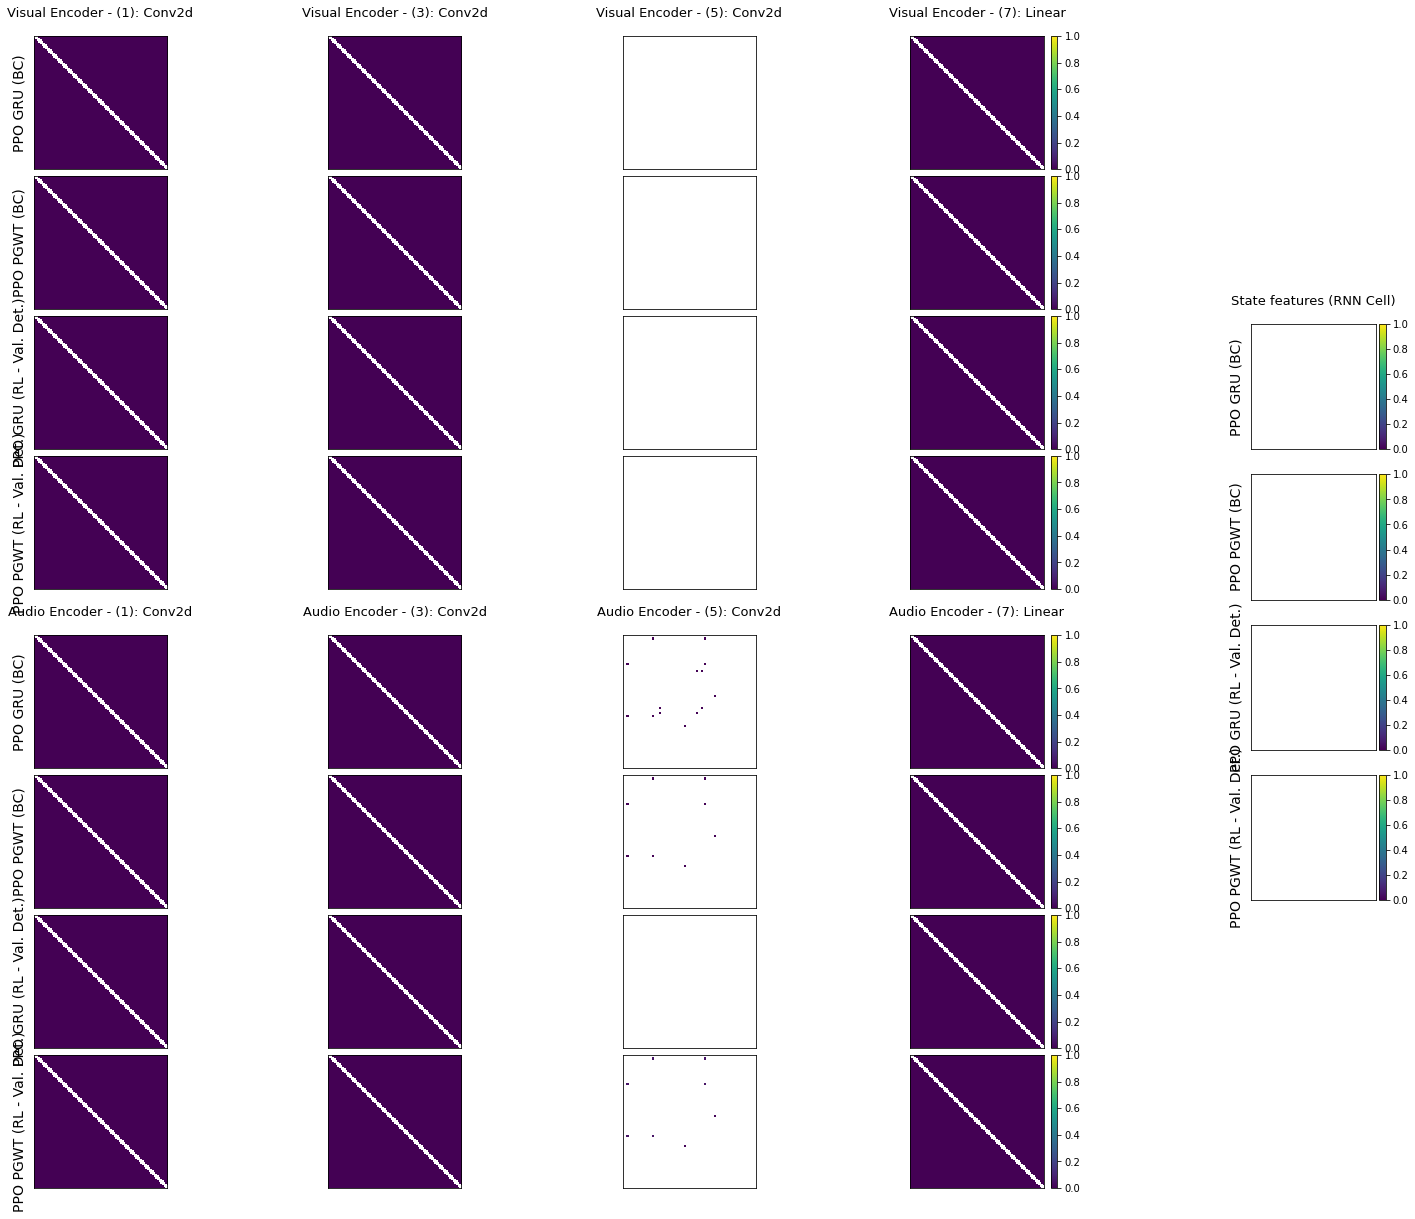

In [87]:
# All in one Plotn

fig = plt.figure(figsize=(22,16))

## General
N_VARIANTS = len(VARIANT_RDMS_MEAN_STD.keys())

## Visual encoder

visual_encoder_layernames.sort()
visual_encoder_layernames_relu_skipped = visual_encoder_layernames[::2]
visual_encoder_layernames_relu_skipped_pretty_names = ["(1): Conv2d", "(3): Conv2d", "(5): Conv2d", "(7): Linear"]

n_rows, n_cols = N_VARIANTS, len(visual_encoder_layernames_relu_skipped)

gs1 = GridSpec(n_rows, n_cols, left=0.0, right=0.735, top=1.0, bottom=0.52, wspace=0.05, hspace=0.05)
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))
# dividers = [make_axes_locatable(a) for a in axes[:, -1]]
# caxes = [ d.append_axes('right', size='5%', pad=0.1) for d in dividers]

vis_enc_axes = [[fig.add_subplot(gs1[i, j]) for j in range(n_cols)] for i in range(n_rows)]
vis_dividers = [make_axes_locatable(row_ax[-1]) for row_ax in vis_enc_axes]
caxes = [ d.append_axes('right', size='5%', pad=0.1) for d in vis_dividers]

# VMIN, VMAX = None, None
VMIN, VMAX = 0, 1
for ax_idx, layername in enumerate(visual_encoder_layernames_relu_skipped):
    for r_idx, (agent_variant, agent_variant_rdm) in enumerate(VARIANTS_RDMS.items()):
        im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername], ax=vis_enc_axes[r_idx][ax_idx],
                                      cmap=mpl.colormaps["viridis"], vmin=VMIN, vmax=VMAX)
        fig.colorbar(im, cax=caxes[r_idx], orientation='vertical')

        vis_enc_axes[r_idx][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=14)
        if r_idx == 0:
            vis_enc_axes[r_idx][ax_idx].set_xlabel(f"Visual Encoder - {visual_encoder_layernames_relu_skipped_pretty_names[ax_idx]}\n", fontsize=13)
            vis_enc_axes[r_idx][ax_idx].xaxis.set_label_position("top")
            

## Audio encoder

audio_encoder_layernames.sort()
audio_encoder_layernames_relu_skipped = audio_encoder_layernames[::2]
audio_encoder_layernames_relu_skipped_pretty_names = ["(1): Conv2d", "(3): Conv2d", "(5): Conv2d", "(7): Linear"]

n_rows, n_cols = N_VARIANTS, len(audio_encoder_layernames_relu_skipped)

# gs2 = GridSpec(n_rows, n_cols, left=0.0, right=0.75, wspace=0)
gs2 = GridSpec(n_rows, n_cols, left=0.0, right=0.735, top=0.48, bottom=0.0, wspace=0.05, hspace=0.05)

aud_enc_axes = [[fig.add_subplot(gs2[i, j]) for j in range(n_cols)] for i in range(n_rows)]
aud_dividers = [make_axes_locatable(row_ax[-1]) for row_ax in aud_enc_axes]
caxes = [ d.append_axes('right', size='5%', pad=0.1) for d in aud_dividers]

# VMIN, VMAX = None, None
VMIN, VMAX = 0, 1
for ax_idx, layername in enumerate(audio_encoder_layernames_relu_skipped):
    for r_idx, (agent_variant, agent_variant_rdm) in enumerate(VARIANTS_RDMS.items()):
        im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm[layername], ax=aud_enc_axes[r_idx][ax_idx],
                                      cmap=mpl.colormaps["viridis"], vmin=VMIN, vmax=VMAX)
        fig.colorbar(im, cax=caxes[r_idx], orientation='vertical')

        aud_enc_axes[r_idx][0].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=14)
        if r_idx == 0:
            aud_enc_axes[r_idx][ax_idx].set_xlabel(f"Audio Encoder - {audio_encoder_layernames_relu_skipped_pretty_names[ax_idx]}\n", fontsize=13)
            aud_enc_axes[r_idx][ax_idx].xaxis.set_label_position("top")

## State features

n_rows, n_cols = N_VARIANTS, 1
gs3 = GridSpec(n_rows, n_cols, left=0.765, right=0.95, top=0.75, bottom=0.25, wspace=0)

state_feat_axes = [fig.add_subplot(gs3[r_idx, 0]) for r_idx in range(n_rows)]
state_feat_dividers = [make_axes_locatable(a) for a in state_feat_axes]
state_feat_cax = [ d.append_axes('right', size='5%', pad=0.05) for d in state_feat_dividers]

for r_idx, (agent_variant, agent_variant_rdm) in enumerate(VARIANTS_RDMS.items()):
    im = rsatoolbox.vis.show_rdm_panel(agent_variant_rdm["state_encoder"], ax=state_feat_axes[r_idx],
                                       cmap=mpl.colormaps["viridis"], vmin=0, vmax=1)
    [fig.colorbar(im, cax=cax_i, orientation='vertical') for cax_i in state_feat_cax]

    state_feat_axes[r_idx].set_ylabel(MODEL_VARIANTS_TO_STATEDICT_PATH[agent_variant]["pretty_name"], fontsize=14)
    
state_feat_axes[0].set_xlabel("State features (RNN Cell)\n", fontsize=13, position="above")
state_feat_axes[0].xaxis.set_label_position("top")

# TODO: position this on top better
# fig.suptitle("Component's Layer-wise Whitened Cosine-based Average Dissimilarity", fontsize=18)
# fig.tight_layout()
fig.show()

/home/rousslan/anaconda3/envs/ss-hab-headless-py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rousslan/anaconda3/envs/ss-hab-headless-py39/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/rousslan/anaconda3/envs/ss-hab-headless-py39/lib/python3.9/site-packages/rsatoolbox/rdm/compare.py:468: RuntimeWarning: invalid value encountered in true_divide
  cos /= np.sqrt(np.einsum('ij,ij->i', vector1, vector1)).reshape((-1, 1))


ValueError: rdm1 and rdm2 have different nan positions

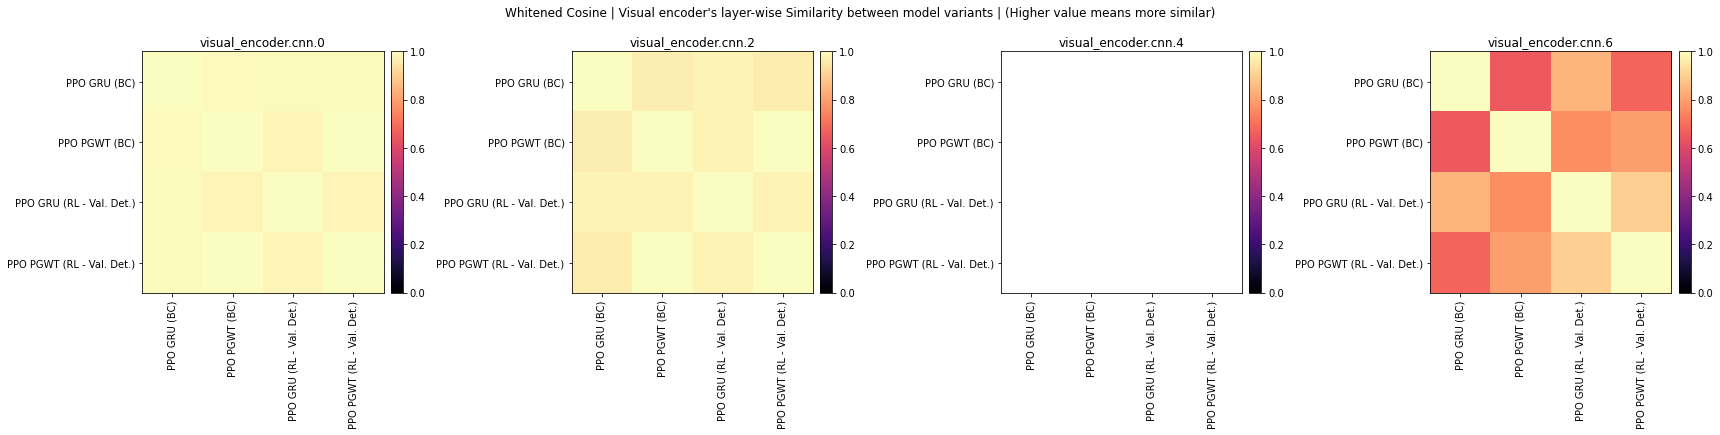

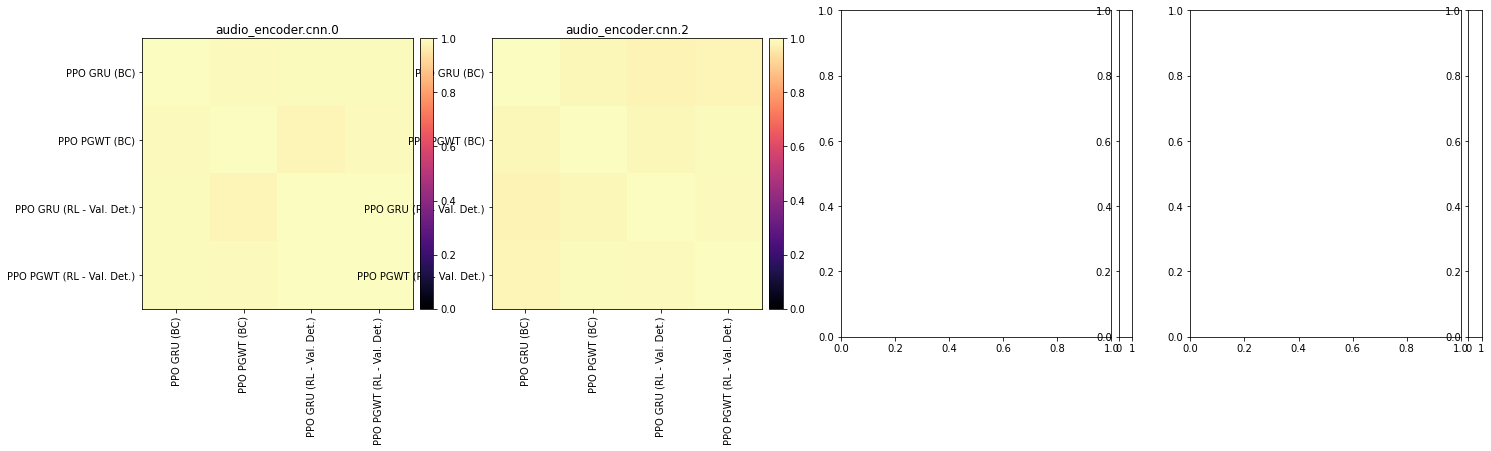

In [88]:
# RDM comparisons
N_VARIANTS = len(list(VARIANTS_RDMS.keys()))
xy_ticks = np.arange(N_VARIANTS)
xy_labels = [MODEL_VARIANTS_TO_STATEDICT_PATH[k]["pretty_name"] for k, _ in VARIANTS_RDMS.items()]
rdm_comparisons = np.zeros([N_VARIANTS, N_VARIANTS])

# Comparison method
METHOD="cosine"
METHOD="spearman"
# TODO: optimze by computing only upper or lower triangle of the matrix

## Visual encoder
visual_encoder_layernames.sort()
visual_encoder_layernames_relu_skipped = visual_encoder_layernames[::2]

n_rows, n_cols = 1, len(visual_encoder_layernames_relu_skipped)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))
dividers = [make_axes_locatable(a) for a in axes]
caxes = [ d.append_axes('right', size='5%', pad=0.1) for d in dividers]

for layer_idx, layername in enumerate(visual_encoder_layernames_relu_skipped):
    # Precompute the RDM compariso matrix
    for i, (agent_i_variant, i_rdms) in enumerate(VARIANTS_RDMS.items()):
        for j, (agent_j_variant, j_rdms) in enumerate(VARIANTS_RDMS.items()):
            rdm_comparisons[i, j] = rsatoolbox.rdm.compare(i_rdms[layername], j_rdms[layername], method=METHOD)
    
    # Plot comparison RDM matrix
    VMIN, VMAX = rdm_comparisons.min(), rdm_comparisons.max() # use the min and max value of similarity value to emphasize the difference
    VMIN, VMAX = 0, 1 # Classical colorbar size
    im = axes[layer_idx].imshow(rdm_comparisons, cmap=mpl.colormaps["magma"], vmin=VMIN, vmax=VMAX)
    fig.colorbar(im, cax=caxes[layer_idx])
    axes[layer_idx].set_xticks(xy_ticks, labels=xy_labels, rotation="vertical"), axes[layer_idx].set_yticks(xy_ticks, labels=xy_labels)
    axes[layer_idx].set_title(layername)

fig.suptitle("Whitened Cosine | Visual encoder's layer-wise Similarity between model variants | (Higher value means more similar)")
fig.tight_layout()
fig.show()

## Audio encoder
audio_encoder_layernames.sort()
audio_encoder_layernames_relu_skipped = audio_encoder_layernames[::2]

n_rows, n_cols = 1, len(audio_encoder_layernames_relu_skipped)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))
dividers = [make_axes_locatable(a) for a in axes]
caxes = [ d.append_axes('right', size='5%', pad=0.1) for d in dividers]

for layer_idx, layername in enumerate(audio_encoder_layernames_relu_skipped):
    # Precompute the RDM compariso matrix
    for i, (agent_i_variant, i_rdms) in enumerate(VARIANTS_RDMS.items()):
        for j, (agent_j_variant, j_rdms) in enumerate(VARIANTS_RDMS.items()):
            rdm_comparisons[i, j] = rsatoolbox.rdm.compare(i_rdms[layername], j_rdms[layername], method=METHOD)
    
    # Plot comparison RDM matrix
    VMIN, VMAX = rdm_comparisons.min(), rdm_comparisons.max() # use the min and max value of similarity value to emphasize the difference
    VMIN, VMAX = 0, 1 # Classical colorbar size
    im = axes[layer_idx].imshow(rdm_comparisons, cmap=mpl.colormaps["magma"], vmin=VMIN, vmax=VMAX)
    fig.colorbar(im, cax=caxes[layer_idx])
    axes[layer_idx].set_xticks(xy_ticks, labels=xy_labels, rotation="vertical"), axes[layer_idx].set_yticks(xy_ticks, labels=xy_labels)
    axes[layer_idx].set_title(layername)

fig.suptitle("Whitened Cosine | Audio encoder's layer-wise Similarity between model variants | (Higher value means more similar)")
fig.tight_layout()
fig.show()

# State encoder (state features)
for i, (agent_i_variant, i_rdms) in enumerate(VARIANTS_RDMS.items()):
    for j, (agent_j_variant, j_rdms) in enumerate(VARIANTS_RDMS.items()):
        # RDMs are compute for each layer
        for layername in ["state_encoder"]: # TODO: broader comparison across other intermediate layers
            rdm_comparisons[i, j] = rsatoolbox.rdm.compare(i_rdms[layername], j_rdms[layername], method=METHOD)

# Plotting RDM comparision matp
fig, ax = plt.subplots(1,1, figsize=((6,6)))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

VMIN, VMAX = rdm_comparisons.min(), rdm_comparisons.max() # use the min and max value of similarity value to emphasize the difference
VMIN, VMAX = 0, 1 # Classical colorbar size
im = ax.imshow(rdm_comparisons, cmap=mpl.colormaps["magma"], vmin=VMIN, vmax=VMAX)
fig.colorbar(im, cax=cax, orientation='vertical')
ax.set_title("state_encoder")

ax.set_xticks(xy_ticks, labels=xy_labels, rotation="vertical"), ax.set_yticks(xy_ticks)
ax.set_xticklabels(xy_labels), ax.set_yticklabels(xy_labels)
fig.suptitle("Whitened Cosine | Layer-wise Similarity between model variants\n(Higher value means more similar)")
fig.show()

In [70]:
# TODO: all in one plots for the paper, potentially add plots for the critic and value distribution, especially if we add those varaints into the comparison
# TODO: more summary

# Sparsity Analysis

In [ ]:
# Sparsity plots components wise
## Note for interpretation: higher sparsity values means that neurons specialize to a certain type of input.
## From the paper, "Higher sparsity values means individual units respnd selectively to a smaller number of images"

from ast import Pass


N_VARIANTS = len(list(VARIANT_LAYERS_SPARSITIES.keys()))
x_ticks = np.arange(N_VARIANTS)
x_tickslabels = [MODEL_VARIANTS_TO_STATEDICT_PATH[k]["pretty_name"] for k, _ in VARIANTS_RDMS.items()]

# TODO: make it a single plot later, with one subplots for each different componets ?
## Visual encoder section
visual_encoder_layernames.sort()
visual_encoder_layernames_relu_skipped = visual_encoder_layernames[::2]

n_rows, n_cols = 1, len(visual_encoder_layernames_relu_skipped)
fig, axes = plt.subplots(1, n_cols, figsize=(n_cols * 4, n_rows * 8))

for ax_idx, layername in enumerate(visual_encoder_layernames_relu_skipped):
    violin_parts = axes[ax_idx].violinplot([
        agent_varaint_sparsities[layername] for _, agent_varaint_sparsities in VARIANT_LAYERS_SPARSITIES.items()
    ], positions=x_ticks, showmedians=True)

    # TODO: darker orange for the PPO PGWT varaint
    # TODO: systematic color application
    # violin_parts["bodies"][1].set_facecolor("orange")
    # violin_parts["bodies"][1].set_edgecolor("orange")
    
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = violin_parts[partname]
        # vp.set_edgecolor("orange")
        vp.set_linewidth(2.5)
    violin_parts["cmedians"].set_edgecolor("red")

    axes[ax_idx].set_xticks(x_ticks, labels=x_tickslabels, rotation="vertical")
    # axes[ax_idx].set_xticklabels(x_tickslabels)
    axes[ax_idx].set_title(layername)

fig.set_facecolor("white")
fig.suptitle("Layer-wise sparsity for the Visual Encoder")
fig.tight_layout()
fig.show()

## Audio encoder section
audio_encoder_layernames.sort()
audio_encoder_layernames_relu_skipped = audio_encoder_layernames[::2]

n_rows, n_cols = 1, len(audio_encoder_layernames_relu_skipped)
fig, axes = plt.subplots(1, n_cols, figsize=(n_cols * 4, n_rows * 8))

for ax_idx, layername in enumerate(audio_encoder_layernames_relu_skipped):
    violin_parts = axes[ax_idx].violinplot([
        agent_varaint_sparsities[layername] for _, agent_varaint_sparsities in VARIANT_LAYERS_SPARSITIES.items()
    ], positions=x_ticks, showmedians=True)

    # TODO: darker orange for the PPO PGWT varaint
    # TODO: systematic color application
    # violin_parts["bodies"][1].set_facecolor("orange")
    # violin_parts["bodies"][1].set_edgecolor("orange")
    
    for partname in ('cbars','cmins','cmaxes','cmedians'):
        vp = violin_parts[partname]
        # vp.set_edgecolor("orange")
        vp.set_linewidth(2.5)
    violin_parts["cmedians"].set_edgecolor("red")

    axes[ax_idx].set_xticks(x_ticks, labels=x_tickslabels, rotation="vertical")
    # axes[ax_idx].set_xticklabels(x_tickslabels)
    axes[ax_idx].set_title(layername)

fig.set_facecolor("white")
fig.suptitle("Layer-wise sparsity for the Visual Encoder")
fig.tight_layout()
fig.show()

# region: state features sparsity violin plot
VARIANT_ALLLAYERS_SPARSITIES = {}
for agent_variant, agent_variant_layers_sparsities in VARIANT_LAYERS_SPARSITIES.items():
    for layername, agent_layer_sparsities in agent_variant_layers_sparsities.items():
        if agent_variant not in VARIANT_ALLLAYERS_SPARSITIES.keys():
            VARIANT_ALLLAYERS_SPARSITIES[agent_variant] = []
        VARIANT_ALLLAYERS_SPARSITIES[agent_variant].extend(agent_layer_sparsities)

fig.set_facecolor("white")
fig.tight_layout()
fig.show()

fig, ax = plt.subplots(1,1, figsize=(4,8))
violin_parts = ax.violinplot([
    agent_varaint_sparsities["state_encoder"] for _, agent_varaint_sparsities in VARIANT_LAYERS_SPARSITIES.items()
], positions=x_ticks, showmedians=True)
# TODO: darker orange for the PPO PGWT varaint
# violin_parts["bodies"][1].set_facecolor("orange")
# violin_parts["bodies"][1].set_edgecolor("orange")
violin_parts["cmedians"].set_edgecolor("red")

for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = violin_parts[partname]
    # vp.set_edgecolor("orange")
    vp.set_linewidth(2.5)
violin_parts["cmedians"].set_edgecolor("red")

ax.set_xticks(x_ticks, labels=x_tickslabels, rotation="vertical")
fig.suptitle("Agent network overal sparsity")
fig.tight_layout()
fig.show()
# endregion: state features sparsity violin plot

# region: For the whole network + violin
VARIANT_ALLLAYERS_SPARSITIES = {}
for agent_variant, agent_variant_layers_sparsities in VARIANT_LAYERS_SPARSITIES.items():
    for layername, agent_layer_sparsities in agent_variant_layers_sparsities.items():
        if agent_variant not in VARIANT_ALLLAYERS_SPARSITIES.keys():
            VARIANT_ALLLAYERS_SPARSITIES[agent_variant] = []
        VARIANT_ALLLAYERS_SPARSITIES[agent_variant].extend(agent_layer_sparsities)

fig.set_facecolor("white")
fig.tight_layout()
fig.show()

fig, ax = plt.subplots(1,1, figsize=(4,8))
violin_parts = ax.violinplot([
    agent_variant_all_sparsities for _, agent_variant_all_sparsities in VARIANT_ALLLAYERS_SPARSITIES.items()
], positions=x_ticks, showmedians=True)
# TODO: darker orange for the PPO PGWT varaint
# violin_parts["bodies"][1].set_facecolor("orange")
# violin_parts["bodies"][1].set_edgecolor("orange")
violin_parts["cmedians"].set_edgecolor("red")

for partname in ('cbars','cmins','cmaxes','cmedians'):
    vp = violin_parts[partname]
    # vp.set_edgecolor("orange")
    vp.set_linewidth(2.5)
violin_parts["cmedians"].set_edgecolor("red")

ax.set_xticks(x_ticks, labels=x_tickslabels, rotation="vertical")
fig.suptitle("Agent network overal sparsity")
fig.tight_layout()
fig.show()
# endregion: For the whole network + violin